In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import loompy
import velocyto as vcy
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
import cytograph as cg
import loompy
import numpy as np
import scipy.sparse as sparse
import torch
from torch.distributions.poisson import Poisson
from torch.autograd import Variable
from torch.nn import MSELoss
from tqdm import trange
from types import SimpleNamespace
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection

2019-01-17 17:00:47,360 INFO: ERROR: failed to import igraph; some clustering methods will not work
/Users/stelin/anaconda53/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
2019-01-17 17:00:51,184 DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


In [6]:
import math
def pcw(age: str) -> float:
    age = age.lower()
    if age.startswith("crl"):
        crl = float(age[3:])
        return (math.sqrt((crl * 1.037)) * 8.052 + 21.73) / 7
    elif " " in age:
        w, d = age.split(" ")
        if not w.endswith("w"):
            raise ValueError("Invalid age string: " + age)
        if not d.endswith("d"):
            raise ValueError("Invalid age string: " + age)
        return int(w[:-1]) + int(d[:-1]) / 7
    else:
        if not age.endswith("w"):
            raise ValueError("Invalid age string: " + age)
        w, d = age[:-1].split(".")
        return int(w) + int(d) / 7


In [7]:
pcw("7.2w")

7.285714285714286

In [2]:
f = "/Users/stelin/build_20181213/L1_Subcortex.loom"

In [52]:
with loompy.connect(f) as ds:
    rnn = ds.col_graphs.RNN

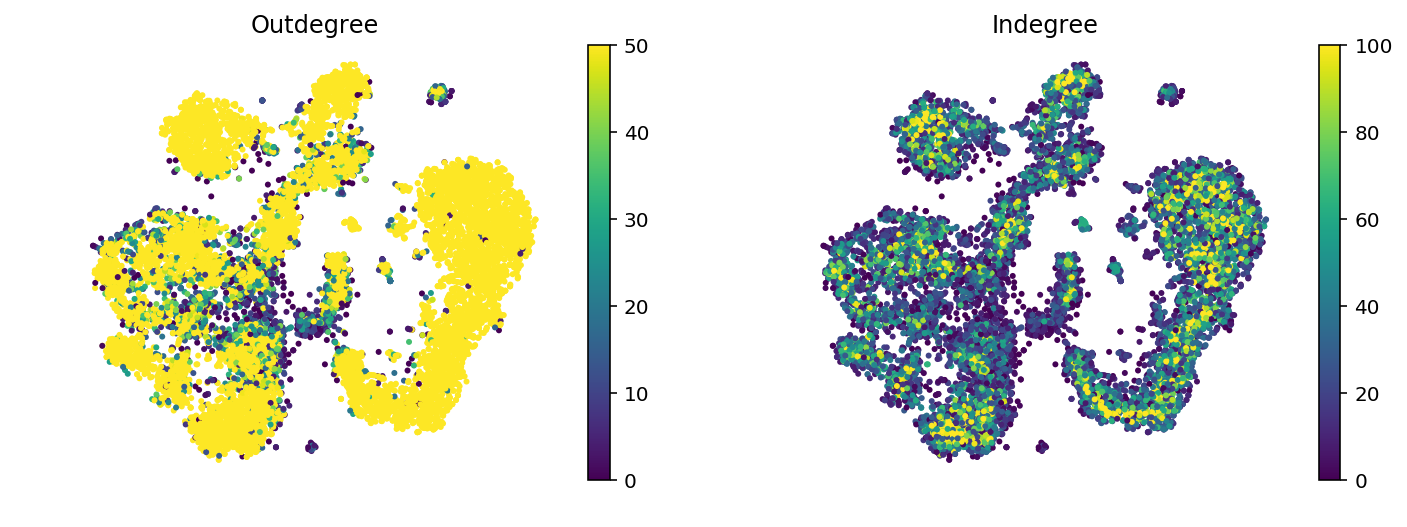

In [53]:
with loompy.connect(f) as ds:
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    cax = plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c=np.bincount(rnn.row), marker='.',lw=0)
    plt.colorbar(cax)
    plt.axis("off")
    plt.title("Outdegree")
    plt.subplot(122)
    cax = plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c=np.bincount(rnn.col), marker='.',lw=0)
    plt.colorbar(cax)
    plt.axis("off")
    plt.title("Indegree")

In [54]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

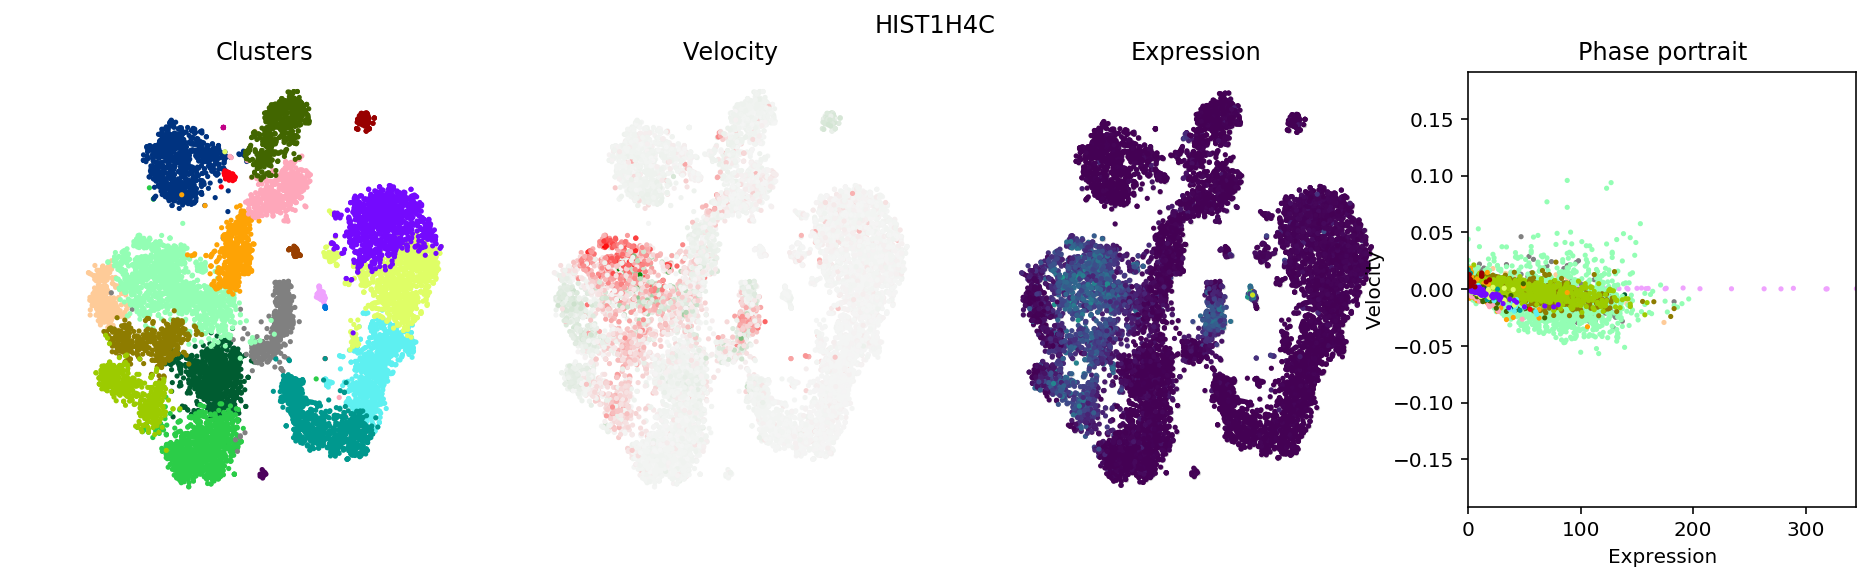

In [55]:

with loompy.connect(f) as ds:
    gene = "HIST1H4C"
    genes = ds.ra.Gene
    g = ds.ra.Gamma[genes == gene]
    s = ds["spliced"][ds.ra.Gene == gene, :][0]
    u = ds["unspliced_exp"][ds.ra.Gene == gene, :][0]
    v = ds["velocity"][ds.ra.Gene == gene, :][0]
    c = ds.ca.Clusters
    vcmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","whitesmoke","green"])
    norm = MidpointNormalize(midpoint=0)

    plt.figure(figsize=(16,4))
    plt.suptitle(gene)
    plt.subplot(141)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=cg.colorize(c), marker='.',s=10)
    plt.title("Clusters")
    plt.axis("off")
    plt.subplot(142)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=v,norm=norm, cmap=vcmap, marker='.',s=10)
    plt.title("Velocity")
    plt.axis("off")
    plt.subplot(143)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c="lightgrey", cmap="viridis", marker='.',s=10)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=s, cmap="viridis", marker='.',s=10)
    plt.title("Expression")
    plt.axis("off")
    plt.subplot(144)
    plt.scatter(s, v, c=cg.colorize(c), marker='.',s=10)
    maxs = np.max(s)
    #plt.plot([0, maxs], [0, maxs*g], 'r--', color = 'b')
    plt.title("Phase portrait")
    plt.xlim(0, maxs)
    plt.ylim(-2*np.max(v), 2*np.max(v))
    plt.xlabel("Expression")
    plt.ylabel("Velocity")

In [7]:


def softplus(x, alpha):
    # This is a dampened version of softplus, which is much closer to relu than standard softplus
    # It also risks overflow...
    return torch.log(1 + torch.exp(alpha * x)) / alpha + 0.000001

class TimeDilationInference:
    def __init__(self, lr: float = 0.01, n_epochs: int = 100) -> None:
        self.lr = lr
        self.n_epochs = n_epochs
        self.losses: List[float] = []
        self.dt: np.ndarray = None
        self.b: np.ndarray = None
        self.g: np.ndarray = None

    def fit(self, ds: loompy.LoomConnection) -> None:
        # Load the data
        n_cells = ds.shape[1]
        self.nn = ds.col_graphs.RNN
        n_edges = self.nn.data.shape[0]
        selected = ds.ra.Selected == 1
        n_selected = selected.sum()
        g_data = ds.ra.Gamma[selected]
        s_data = np.empty((n_selected, n_cells))
        v_data = np.empty((n_selected, n_cells))
        r = 0
        for (_, _, view) in ds.scan(items=selected, axis=0, layers=["spliced_exp", "velocity"]):
            v_data[r:r + view.shape[0], :] = view.layers["velocity"][:, :]
            s_data[r:r + view.shape[0], :] = view.layers["spliced_exp"][:, :]
            r += view.shape[0]

        self.model = SimpleNamespace(
            # Inputs
            s = Variable(torch.tensor(s_data, dtype=torch.float), requires_grad=False),
            u = Variable(torch.tensor(u_data, dtype=torch.float), requires_grad=False),
            v = Variable(torch.tensor(v_data, dtype=torch.float), requires_grad=False),
            si = Variable(torch.tensor(s_data[:, self.nn.row], dtype=torch.float), requires_grad=False),
            sj = Variable(torch.tensor(s_data[:, self.nn.col], dtype=torch.float), requires_grad=False),
            ix = Variable(torch.tensor(self.nn.row, dtype=torch.long), requires_grad=False),
            jx = Variable(torch.tensor(self.nn.col, dtype=torch.long), requires_grad=False),
            # Model parameters, to be optimized
            b = Variable(torch.tensor(np.random.uniform(1, 1.01, size=n_selected), dtype=torch.float), requires_grad=False),
            dt = Variable(torch.tensor(np.random.normal(size=n_edges), dtype=torch.float), requires_grad=True),
            g = Variable(torch.tensor(g_data, dtype=torch.float), requires_grad=False)
        )
        #return self.epochs(self.n_epochs)
    
    def epochs(self, n_epochs: int, lr: float = None) -> None:
        if lr is not None:
            self.lr = lr
        m = self.model
        optimizer = torch.optim.SGD([m.dt], lr=self.lr)
        t = trange(n_epochs)

        for epoch in t:
            optimizer.zero_grad()
            #t.set_description("Zeroed gradients")
            ## Set up the computation graph for the log-likelihood
            # Estimate velocity given beta and gamma
            v = m.b.unsqueeze(1) * m.u - m.g.unsqueeze(1) * m.s
            #t.set_description("Estimated velocities")
            # Expand into vectors of velocities for source and target cells
            vi = v[:, m.ix]
            #t.set_description("Expanded vector i")
            vj = v[:, m.jx]
            #t.set_description("Expanded vector j")

            # Extrapolate from source to target; use softplus to prevent negative or zero values after extrapolation
            extrapolated_fw = softplus(m.si + m.dt * vi, 10)  # softplus prevents negative values for extrapolation
            #t.set_description("Extrapolated fw")
            # Calculate the MSE at the extrapolated value
            loss = MSELoss()(extrapolated_fw, m.sj)
            #t.set_description("Loss fw")
            # Extrapolate from target to source
            extrapolated_rev = softplus(m.sj - m.dt * vj, 10)
            #t.set_description("Extrapolated rev")
            # Add to the loss
            loss += MSELoss()(extrapolated_rev, m.si)
            #t.set_description("Loss rev")

            self.losses.append(float(loss))
            loss.backward()
            #t.set_description("backward")
            optimizer.step()
            #t.set_description("step")
            m.b.data.clamp_(min=0)
            #m.g.data.clamp_(min=0.001)
            t.set_description(f"loss={loss}")
            t.refresh()
    
        self.dt = m.dt.detach().numpy()
        self.b = m.b.detach().numpy()
        self.g = m.g.detach().numpy()
        #self.gt = m.gt.detach().numpy()
        return self

In [9]:
with loompy.connect(f) as ds:
    tdi = TimeDilationInference(lr=0.01)
    tdi.fit(ds)

In [10]:
tdi.epochs(2)

loss=0.00963693205267191: 100%|██████████| 2/2 [00:25<00:00, 12.62s/it]


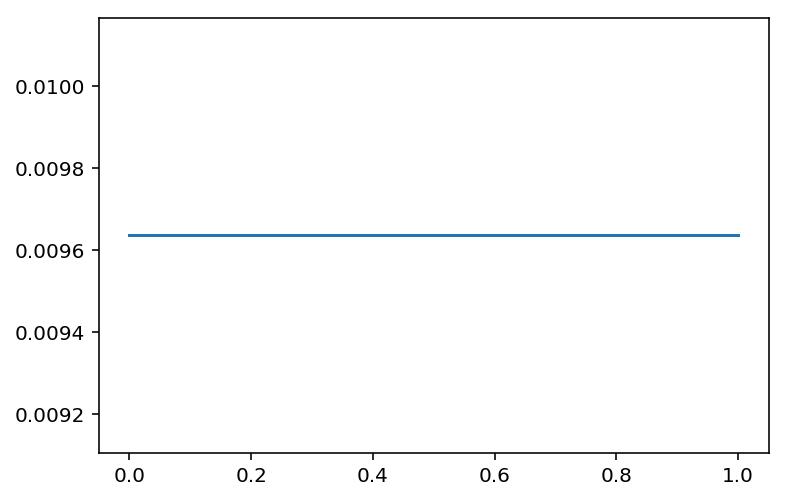

In [11]:
plt.plot(np.arange(len(tdi.losses)), tdi.losses)

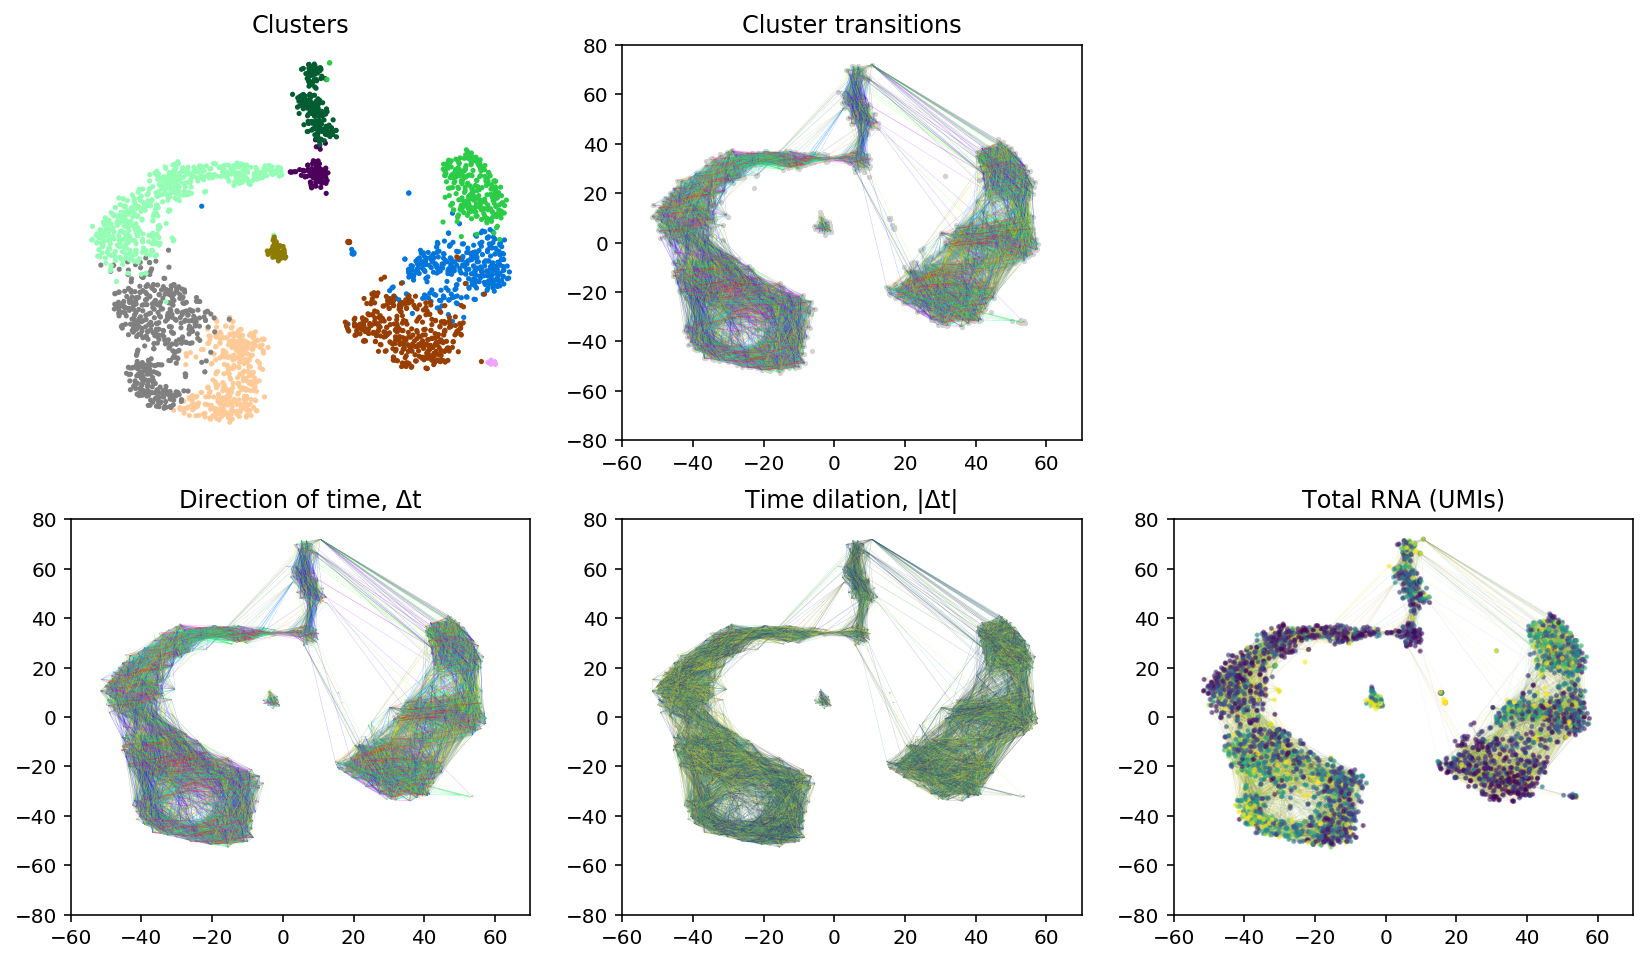

In [55]:

vcmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["magenta","whitesmoke","green"])
with loompy.connect(f) as ds:
    nn = tdi.nn
    (a, b, w) = (nn.row, nn.col, nn.data)
    longest = ds.ca.Clusters[a] != 93 # ds.ca.Clusters[b]
    w = w[longest]
    a = a[longest]
    b = b[longest]
    pos = ds.ca.TSNE
    plt.figure(figsize=(14,8))
    plt.subplot(231)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=cg.colorize(ds.ca.Clusters), marker='.',s=10)
    plt.title("Clusters")
    plt.axis("off")
    ax = plt.subplot(232)
    dt = tdi.model.dt.detach().numpy()
    dt = dt[longest]
    deltas = pos[a] - pos[b]
    angles = np.arctan2(deltas[:,1], deltas[:,0]) + np.pi
    angles[dt < 0] = np.mod(angles[dt < 0] + np.pi, 2*np.pi)
    lc = LineCollection(zip(pos[a], pos[b]), linewidths=0.25, color=plt.cm.gist_rainbow(angles/6.28), alpha=0.25)
    ax.add_collection(lc)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c='lightgrey', marker='.',s=10)
    plt.xlim(-60,70)
    plt.ylim(-80, 80)
    plt.title("Cluster transitions")

    ax = plt.subplot(234)
    dt = tdi.model.dt.detach().numpy()
    dt = dt[longest]
    deltas = pos[a] - pos[b]
    angles = np.arctan2(deltas[:,1], deltas[:,0]) + np.pi
    angles[dt < 0] = np.mod(angles[dt < 0] + np.pi, 2*np.pi)
    lc = LineCollection(zip(pos[a], pos[b]), linewidths=0.25, zorder=0, color=plt.cm.gist_rainbow(angles/6.28), alpha=0.25)
    ax.add_collection(lc)
    plt.xlim(-60,70)
    plt.ylim(-80, 80)
    plt.title("Direction of time, Δt")
    ax = plt.subplot(235)
    dt = tdi.model.dt.detach().numpy()
    lc = LineCollection(zip(pos[a], pos[b]), linewidths=0.25, zorder=0, color=plt.cm.viridis(abs(dt)), alpha=0.25)
    ax.add_collection(lc)
    plt.xlim(-60,70)
    plt.ylim(-80, 80)
    plt.title("Time dilation, |Δt|")
    ax = plt.subplot(236)
    lc = LineCollection(zip(pos[a], pos[b]), linewidths=0.25, zorder=0, color=plt.cm.viridis(abs(dt)*2), alpha=0.1)
    ax.add_collection(lc)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=ds.ca.TotalRNA, alpha=0.5, vmin=2071, vmax=4936, cmap="viridis", marker='.',s=10)
    plt.xlim(-60,70)
    plt.ylim(-80, 80)
    plt.title("Total RNA (UMIs)")

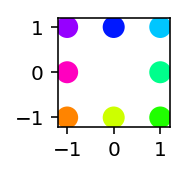

In [23]:
plt.figure(figsize=(1,1))
deltas = np.array([[1,0],[1, 1], [0, 1], [-1, 1], [-1, 0], [-1,-1], [0,-1], [1,-1]])
angles = np.arctan2(deltas[:,1], deltas[:,0]) + np.pi
#angles[0] = np.mod(angles[0] + 3.14, 6.28)
c = plt.cm.gist_rainbow(angles/6.28)
plt.scatter(x=deltas[:,0],y=deltas[:,1], c=c, s=100)
#plt.scatter(np.sin(angles), np.cos(angles), c=c, s=100,alpha=0.5)

## TODO: plot time dilation for a cell and all its neighbors

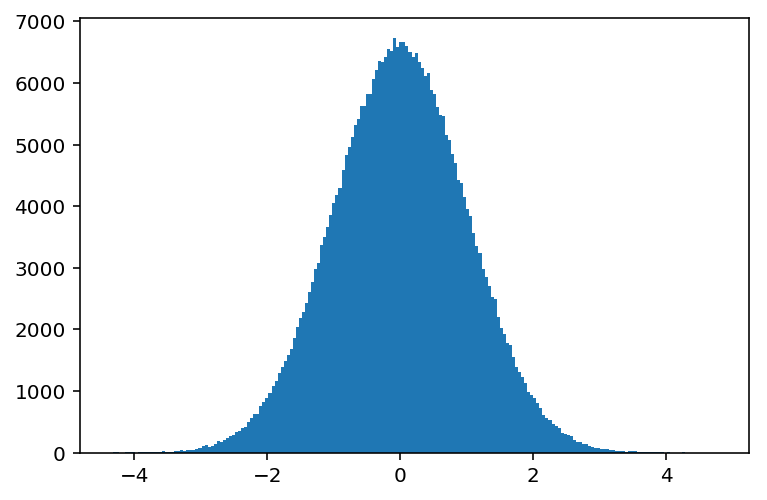

In [24]:
_=plt.hist(tdi.model.dt.detach().numpy(), bins=200)

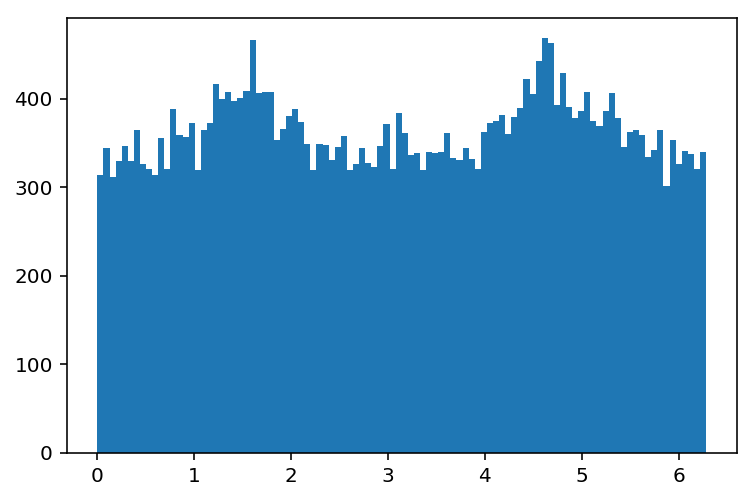

In [56]:
_=plt.hist(angles, bins=100)

(50,) (50,) (50,)


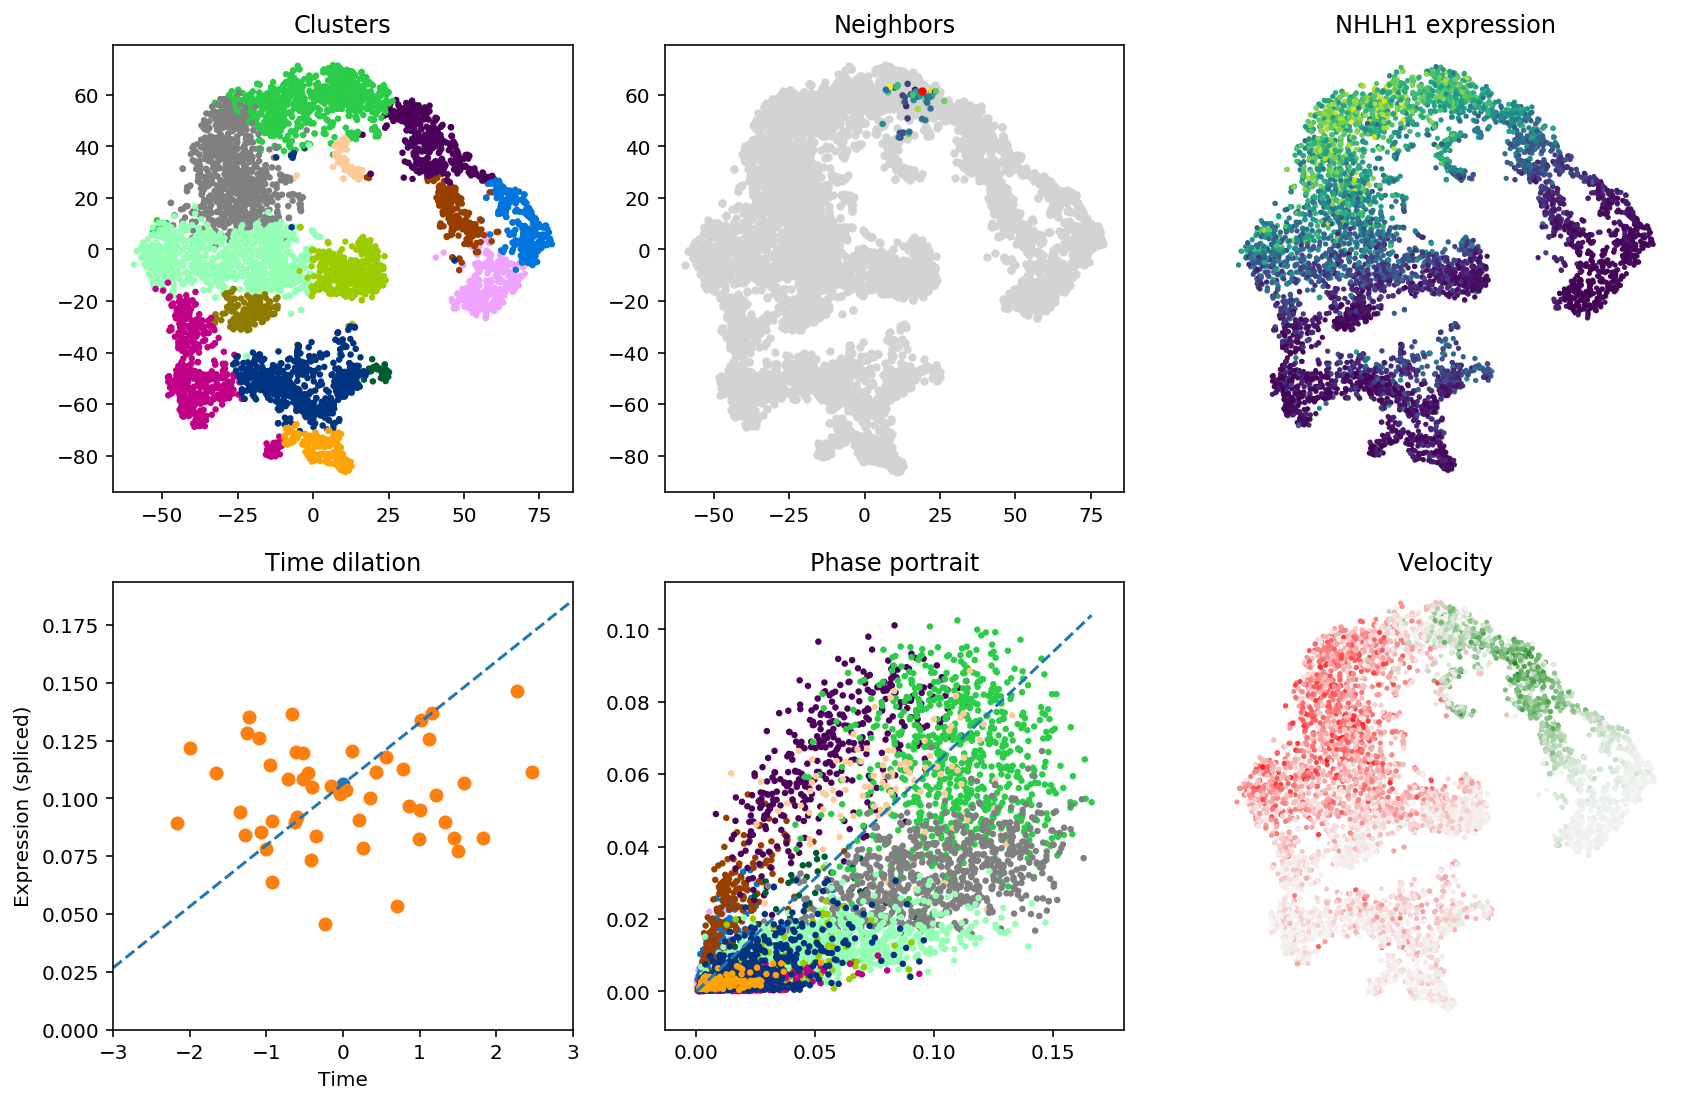

In [20]:
dt = tdi.model.dt.detach().numpy()
with loompy.connect(f) as ds:
    plt.figure(figsize=(14,14))
    gene1_name = "NHLH1"
    gene1 = np.where(ds.ra.Gene == gene1_name)[0]
    s = ds["spliced_exp"][gene1, :][0]
    v = ds["velocity"][gene1, :][0]
    rnn = tdi.nn
    cell1 = np.argsort(s)[-800]
    nns = rnn.col[np.where(rnn.row == cell1)]
    nn_edges = np.where((rnn.row == cell1) & (np.isin(rnn.col, nns)))[0]
    nn_times = dt[nn_edges]

    print(nn_times.shape, nn_edges.shape, nns.shape)
    plt.subplot(331)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=cg.colorize(ds.ca.Clusters), marker='.', s=20)
    plt.title("Clusters")

    plt.subplot(332)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c='lightgrey', marker='.',s=40)
    plt.scatter(ds.ca.TSNE[nns,0], ds.ca.TSNE[nns,1], marker='.',s=20, c=nn_times)
    plt.scatter(ds.ca.TSNE[cell1,0], ds.ca.TSNE[cell1,1], marker='.',s=40, c='red')
    plt.title("Neighbors")
    
    plt.subplot(333)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c="lightgrey", cmap="viridis", marker='.',s=10)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=s, cmap="viridis", marker='.',s=10)
    plt.title(gene1_name + " expression")
    plt.axis("off")
    
    plt.subplot(334)
    x1 = ds["spliced_exp"][gene1, cell1]
    plt.scatter(0, x1)
    v1 = ds["velocity"][gene1, cell1]
    plt.plot([-3, 3], [-3 * v1 + x1, 3 * v1 + x1], linestyle='dashed')
    x2 = ds["spliced_exp"][gene1, :][:, nns]
    plt.scatter(nn_times, x2)
    plt.xlim(-3, 3)
    plt.ylim(0, None)
    plt.title("Time dilation")
    plt.xlabel("Time")
    plt.ylabel("Expression (spliced)")
    
    plt.subplot(335)
    plt.scatter(ds["spliced_exp"][gene1, :], ds["unspliced_exp"][gene1, :], c=cg.colorize(ds.ca.Clusters), marker='.', s=20)
    max_s = np.max(ds["spliced_exp"][gene1, :])
    plt.plot([0,max_s], [0, max_s * ds.ra.Gamma[gene1]], linestyle="dashed")
    #plt.plot([0,max_s], [0, max_s * tdi.g[(ds.ra.Gene[ds.ra.Selected == 1] == gene1_name)]], linestyle="dashed")
    plt.title("Phase portrait")

    plt.subplot(336)
    norm = MidpointNormalize(midpoint=0)
    vcmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","whitesmoke","green"])
    
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=v, norm=norm, cmap=vcmap, marker='.',s=10)
    plt.title("Velocity")
    plt.axis("off")



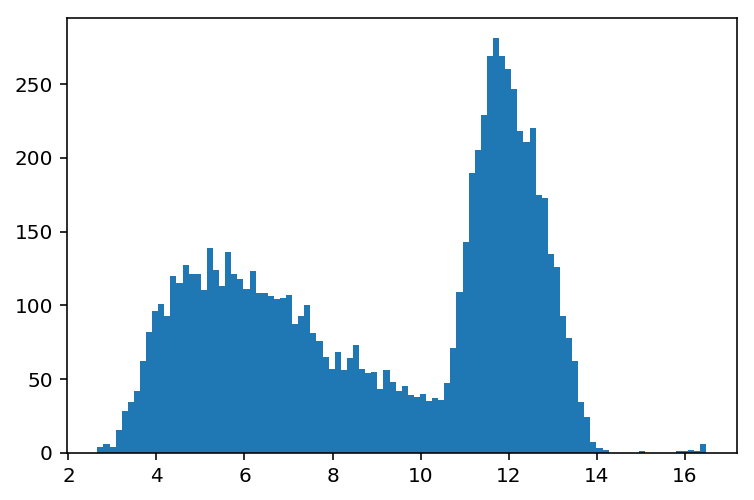

In [238]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Cortex_8w_2.loom") as ds:
    plt.hist(-np.log2(ds.ca.HPF[:, 18]), bins=100)

## Plot velocities in PCA space

2018-12-22 13:50:26,339 DEBUG: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/stelin/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


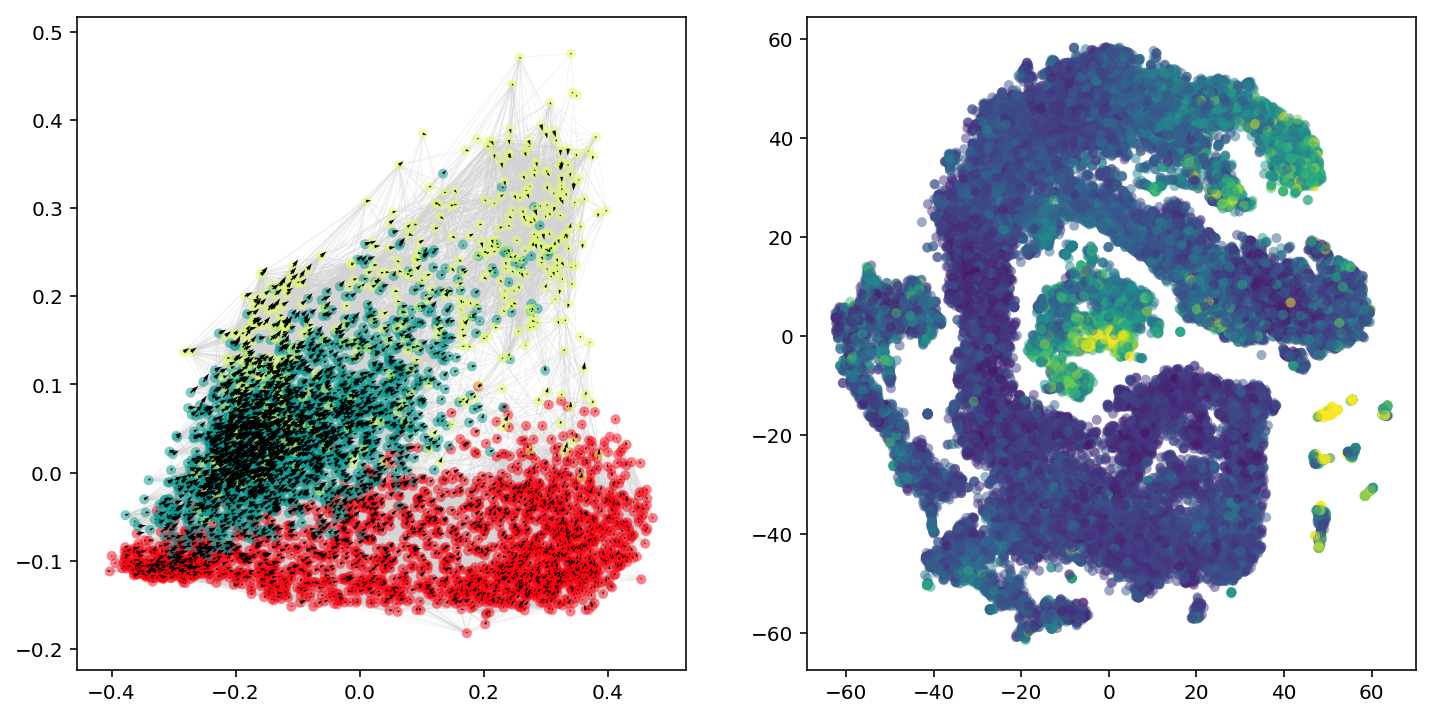

In [3]:
from sklearn.decomposition import PCA
#f = "/Users/stelin/dh_20170213/L1_MidbrainVentral.loom"
f = "/Users/stelin/build_20181213/L1_Cerebellum.loom"
with loompy.connect(f) as ds:
    colors = cg.colorize(ds.ca.Clusters)
    clusters = [16,19,18]
    cells = np.where(np.isin(ds.ca.Clusters, clusters))[0]
    rnn = ds.col_graphs.MKNN
    edges = np.isin(rnn.row, cells) & np.isin(rnn.col, cells)
    (a, b) = (rnn.row[edges], rnn.col[edges]) 
    #sdata = ds["spliced_exp"][ds.ra.Selected == 1, :]
    #vdata = ds["velocity"][ds.ra.Selected == 1, :]
    s = sdata[:, cells].T
    v = vdata[:, cells].T
    pca_transformer = PCA(n_components=2).fit(np.log(s+1))
    pca = pca_transformer.transform(np.log(s+1))
    xpca = pca_transformer.transform(np.log(s + v + 1)) - pca
    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    #plt.scatter(ds.ca.TSNE[cells,0], ds.ca.TSNE[cells,1], c=cg.colorize(ds.ca.Clusters[cells]), marker='.', s=100, alpha=0.5)
    plt.scatter(pca[:,0], pca[:,1], c=colors[cells], marker='.', s=100, alpha=0.5, lw=0)
    plt.quiver(pca[:,0], pca[:,1],xpca[:,0], xpca[:,1])
    pos = np.zeros_like(ds.ca.TSNE)
    pos[cells, :] = pca
    lc = LineCollection(zip(pos[a], pos[b]), linewidths=0.25, zorder=0, color='lightgrey', alpha=0.25)
    ax.add_collection(lc)
    plt.subplot(122)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], vmax=0.8,c=np.linalg.norm(vdata.T, axis=1), lw=0, marker='.', s=100, alpha=0.5)

In [20]:
import ipyvolume as ipv
from sklearn.decomposition import PCA
import numpy as np
f = "/Users/stelin/build_20181213/L1_Cerebellum.loom"
with loompy.connect(f) as ds:
    colors = cg.colorize(ds.ca.Clusters)
    clusters = [5,6,7,8,24]
    cells = np.where(np.isin(ds.ca.Clusters, clusters))[0]
    rnn = ds.col_graphs.RNN
    edges = np.isin(rnn.row, cells) & np.isin(rnn.col, cells)
    (a, b) = (rnn.row[edges], rnn.col[edges]) 
    #sdata = ds["spliced_exp"][ds.ra.Selected == 1, :]
    #vdata = ds["velocity"][ds.ra.Selected == 1, :]
    s = sdata[:, cells].T
    v = vdata[:, cells].T
    pca_transformer = PCA(n_components=3).fit(np.log(s+1))
    pca = pca_transformer.transform(np.log(s+1))
    xpca = pca_transformer.transform(np.log(s + v + 1)) - pca
    x,y,z = pca[:,0], pca[:,1], pca[:,2]
    u,v,w = xpca[:,0], xpca[:,1], xpca[:,2]
    
selected = np.random.randint(0, 1000, 100)
ipv.figure()
quiver = ipv.quiver(x, y, z, u, v, w, color=colors[cells], size=3)

from ipywidgets import FloatSlider, ColorPicker, VBox, jslink
size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()
jslink((quiver, 'size'), (size, 'value'))
jslink((quiver, 'size_selected'), (size_selected, 'value'))
jslink((quiver, 'color'), (color, 'value'))
jslink((quiver, 'color_selected'), (color_selected, 'value'))
VBox([ipv.gcc(), size, size_selected, color, color_selected])

In [130]:
import ipyvolume as ipv

f = "/Users/stelin/build_20181213/L2_Cerebellum_Neural.loom"
#f = "/Users/stelin/dh_20170213/L1_Mouse_Forebrain_E9_11.loom"
with loompy.connect(f) as ds:
    colors = cg.colorize(ds.ca.Clusters)
    umap = ds.ca.UMAP3D
    x,y,z = umap[:,0], umap[:,1], umap[:,2]
    
ipv.figure()
ipv.scatter(x, y, z, color=colors, size=10, marker="point_2d")
ipv.gcc()



OSError: File '/Users/stelin/build_20181213/L2_Cerebellum_Neural.loom' not found

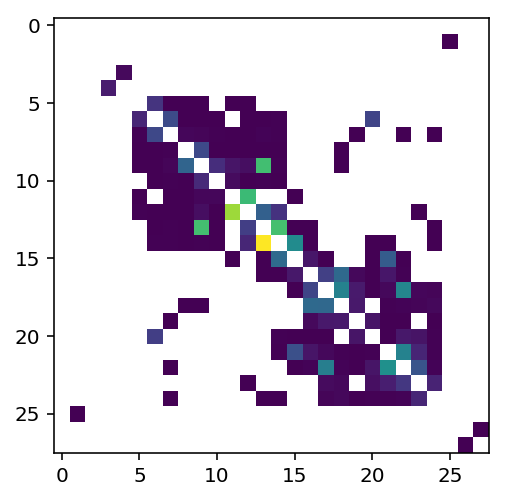

In [16]:
from copy import copy
f = "/Users/stelin/build_20181213/L1_Cerebellum.loom"
with loompy.connect(f) as ds:
    n_clusters = ds.ca.Clusters.max() + 1
    labels = ds.ca.Clusters
    n_cells = ds.shape[1]
    rnn = ds.col_graphs.RNN
    a, b = labels[rnn.row], labels[rnn.col]
    m = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i == j:
                continue
            m[i, j] = ((a == i) & (b == j)).sum()
palette = copy(plt.cm.viridis)
palette.set_over('r', 1.0)
palette.set_under('white', 1.0)
palette.set_bad('b', 1.0)
plt.imshow(m, vmin=0.1, cmap=palette)

In [58]:
def project(a, b):
    return a @ (b / np.linalg.norm(b))
project(np.array([-1,2]), np.array([2,0]))

-1.0

In [23]:
import yaml
with open("/Users/stelin/build_20181213/L2_buckets.yaml") as f:
    bucket_spec = yaml.load(f)

In [24]:
bucket_spec

{'Cerebellum_Neural': {'Cerebellum': [5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23],
  'Midbrain': [2, 3, 4]}}

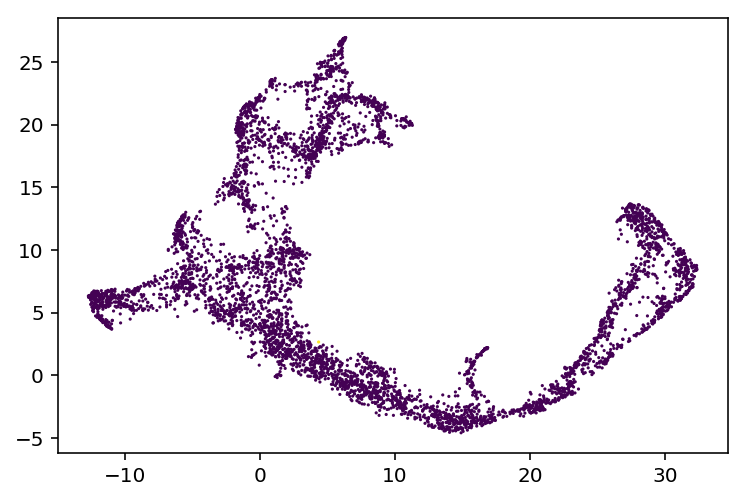

In [51]:
with loompy.connect("/Users/stelin/build_20181213/L2_Cerebellum_Excitatory.loom") as ds:
    plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1],c=ds[ds.ra.Gene=="PIRT",:][0],lw=0,marker='.', s=10)